In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.mcmc.mala import MALAKernel



In [2]:
# initialize jax RNG
key = jr.key(0)

In [ ]:
def make_isotropic_gauss_density(mean, log_var):
    """ create the log_prob function for an isotropic Gaussian distribution """
    def log_density(x):
        return -0.5 * jnp.sum((x - mean) ** 2 / jnp.exp(log_var)) - 0.5 * jnp.sum(log_var)
    return log_density

In [9]:
def Sample_Mala(kernel: MALAKernel, n_samples: int, key: jax.Array, x0: jnp.ndarray, step_size: float):
    params = kernel.init_params(x0, step_size=step_size)
    initial_state = kernel.init_state(x0)
    output = kernel.run_mcmc(
        initial_state=initial_state,
        params=params,
        key=key,
        n_samples=n_samples,
    )
    return output.summary.acceptance_rate


In [11]:
dim_arr = jnp.arange(1, 101, 10)
n_samples = 100_000
acc_rate = {f"acc_rate_arr{i}": [] for i in range(1, 5)}

for dim in dim_arr:
    print(f"Running for dim = {dim}")
    
    # Target distribution
    mu = jnp.full((dim,), 1.0)
    log_var = jnp.log(2.0)
    log_prob = make_isotropic_gauss_density(mu, log_var)

    x0 = jnp.zeros((dim,))
    key, key_ = jr.split(key)

    # Create four MALA kernels with different step size scalings
    step_sizes = [
        1.0,
        1.0 / dim**(1/3),
        1.0 / dim**(1/2),
        1.0 / dim
    ]

    for i, step_size in enumerate(step_sizes, start=1):
        mala = MALAKernel.create(log_prob=log_prob, cov_type="diag")
        acc = Sample_Mala(kernel=mala, n_samples=n_samples, key=key_, x0=x0, step_size=step_size)
        acc_rate[f"acc_rate_arr{i}"].append(acc)


Running for dim = 1
Running for dim = 11
Running for dim = 21
Running for dim = 31
Running for dim = 41
Running for dim = 51
Running for dim = 61
Running for dim = 71
Running for dim = 81
Running for dim = 91


Text(0.5, 1.0, 'Acceptance rate for different scaling schema of step size')

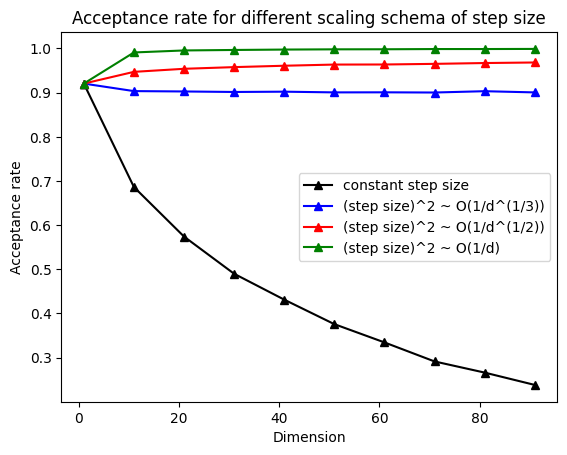

In [12]:
plt.plot(dim_arr,acc_rate["acc_rate_arr1"], "k-^",label="constant step size")
plt.plot(dim_arr,acc_rate["acc_rate_arr2"], "b-^",label="(step size)^2 ~ O(1/d^(1/3))")
plt.plot(dim_arr,acc_rate["acc_rate_arr3"], "r-^",label="(step size)^2 ~ O(1/d^(1/2))")
plt.plot(dim_arr,acc_rate["acc_rate_arr4"], "g-^",label="(step size)^2 ~ O(1/d)")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate for different scaling schema of step size")


In [ ]:
# Efficiency and Acceptance rate
# Set a higher dimension (dim = 20)
dim = 20
# Target distribution
mu = jnp.full(dim,1.)
log_var = jnp.log(2)
log_prob = make_isotropic_gauss_density(mu, log_var)

In [ ]:
# Per-trajectory MALA runner
def sample_Mala(key, x0, step_size, n_samples, dim):
    # Define MALA kernel with dimension-scaled step size
    kernel = MALAKernel.create(
        log_prob=log_prob,  # assumes log_prob is in scope
        cov_type="diag"         # or "full", depending on your usage
    )
    
    initial_state = kernel.init_state(x0)
    params = kernel.init_params(
        x0,
        step_size=(step_size**2) / dim**(1/3)
    )
    
    output = kernel.run_mcmc(
        initial_state=initial_state,
        params=params,
        key=key,
        n_samples=n_samples
    )
    return output

# Compile and batch over step_size
sample_Mala = jax.jit(sample_Mala, static_argnums=(3, 4))
sample_Mala_batch = jax.vmap(sample_Mala, in_axes=(0, None, 0, None, None))
sample_Mala_batch = jax.jit(sample_Mala_batch, static_argnums=(3, 4))


In [15]:
# Experiment parameters
step_size_arr = np.linspace(0.01, 5.0, 100)
n_samples = 100_000
dim = 20  # example dimension
x0 = jnp.zeros((dim,))
keys = jax.random.split(jax.random.PRNGKey(0), len(step_size_arr) + 1)
keys, key_ = keys[:-1], keys[-1]

# Run batch of MCMC chains
mcmc_output_batch = sample_Mala_batch(keys, x0, step_size_arr, n_samples, dim)
traj_batch = jax.block_until_ready(mcmc_output_batch.traj)
summary_batch = mcmc_output_batch.summary


Text(0.5, 1.0, 'Efficiency v.s. Acc rate')

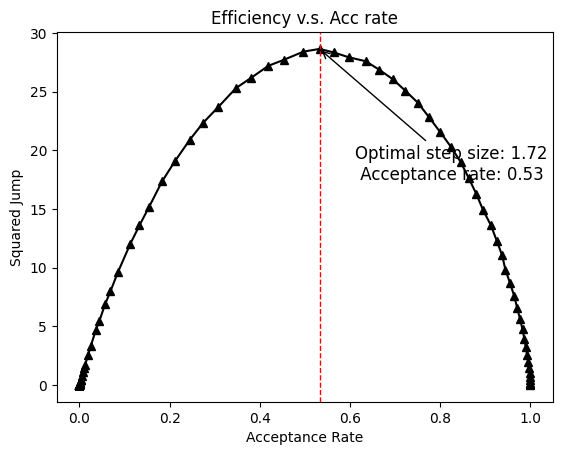

In [17]:
efficiency = [summary_batch.sq_jump[i] for i in range(len(step_size_arr))]
plt.plot(summary_batch.acceptance_rate, efficiency, "-^", color='black')

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(efficiency)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, efficiency[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.xlabel("Acceptance Rate")
plt.ylabel("Squared Jump")
plt.title("Efficiency v.s. Acc rate")